In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import libraries and some constants

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm
import scipy
import pandas as pd
import uproot as ur
import awkward as ak
import atlas_mpl_style as ampl

ampl.use_atlas_style()
params = {'legend.fontsize': 13,
          'axes.labelsize': 18}
plt.rcParams.update(params)

path_prefix = '/AL/Phd/maxml/'
plotpath = path_prefix+'caloml-atlas/classifier/Plots/graph/'
modelpath = path_prefix+'caloml-atlas/classifier/Models/graph/'
inputpath = path_prefix+'caloml-atlas/inputs/'

In [3]:
import sys
sys.path.append(path_prefix+'caloml-atlas/')
sys.path
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu

Using TensorFlow backend.


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow import keras

In [5]:
import tensorflow as tf

gpu_list = ["/gpu:0"]
strategy = tf.distribute.MirroredStrategy(devices=gpu_list)
# strategy = tf.distribute.MirroredStrategy()
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [11]:
def setupGraphImageData(inputpath, ptypes=['pi0','piplus'],
                        files={'pi0':['pi0-graph'],'piplus':['pion-graph']}):
    pdata = {
        label: None
        for label in ptypes
    }
    pcells = {
        label: {}
        for label in ptypes
    }
    for label in ptypes:
        for ifile in files[label]:
            with np.load(inputpath+ifile+'.npz',allow_pickle=True) as data:
                if(pdata[label]==None):
                    pdata[label] = pd.DataFrame(data['pdata'].flatten()[0])
                else:
                    pdata[label].merge(pd.DataFrame(data['pdata'].flatten()[0]),how='outer')

                for layer in mu.cell_meta:
                    if layer in pcells[label]:
                        pcells[label][layer] = np.concatenate((pcells[label][layer],data['pcells'].flatten()[0][layer]),axis=0)
                    else:
                        pcells[label][layer] = data['pcells'].flatten()[0][layer]

    return pcells,pdata

In [7]:
def createGraphTrainingDatasets(ptypes,pdata,pcells):
    for pindex,plabel in enumerate(ptypes):
        mu.splitFrameTVT(pdata[plabel],trainfrac=0.7)
        pdata[plabel]['label'] = pindex
    
    pdata_merged = pd.concat([pdata[plabel] for plabel in ptypes])
    pcells_merged = {
        layer: np.concatenate([pcells[plabel][layer] for plabel in ptypes],axis=0)
        for layer in mu.cell_meta
    }
    labels = keras.utils.to_categorical(pdata_merged['label'],len(ptypes))
    
    return pdata_merged, pcells_merged, labels

In [12]:
pcells,pdata = setupGraphImageData(inputpath)

In [13]:
training_classes = ['pi0','piplus']
pdata_merged, pcells_merged, plabels = createGraphTrainingDatasets(training_classes, pdata, pcells)
pcells_merged_reshaped = mu.reshapeSeparateCNN(pcells_merged)

In [14]:
filters = {
    'EMB1': (2,4), 
    'EMB2': (4,4), 
    'EMB3': (4,2), 
    'TileBar0': (2,2), 
    'TileBar1': (2,2), 
    'TileBar2': (1,1)
}
pools2 = {
    'EMB1': (2,2), 
    'EMB2': (2,2), 
    'EMB3': (1,1), 
    'TileBar0': (1,1), 
    'TileBar1': (1,1), 
    'TileBar2': (1,1)
}
def cnn_model_layers(layer):
    print(layer)
    # create model
    with strategy.scope():
        model = Sequential()
        model.add(Convolution2D(32, filters[layer], input_shape=(1,mu.cell_meta[layer]['len_eta'],mu.cell_meta[layer]['len_phi']), activation='relu', data_format = 'channels_first'))
        model.add(MaxPool2D(pool_size=(2, 2)))
        # model.add(Convolution2D(16, (2, 2), activation='relu'))
        model.add(Convolution2D(16, pools2[layer], activation='relu'))
        model.add(MaxPool2D(pool_size=pools2[layer]))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dense(50, activation='relu'))
        model.add(Dense(2, kernel_initializer='normal', activation='softmax'))
        # compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
        return model

In [15]:
models = {
    layer: cnn_model_layers(layer)
    for layer in mu.cell_meta
}

EMB1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
EMB2
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
EMB3
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
TileBar0
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0'

In [16]:
history = {
    layer: models[layer].fit(pcells_merged_reshaped[layer][pdata_merged.train], 
                                plabels[pdata_merged.train], 
                                validation_data=(pcells_merged_reshaped[layer][pdata_merged.val], plabels[pdata_merged.val]),                                   epochs=100, batch_size=200*ngpu, verbose=2)
    for layer in mu.cell_meta
}

Train on 35483 samples, validate on 5071 samples
Epoch 1/100
35483/35483 - 7s - loss: 0.6785 - acc: 0.5860 - val_loss: 0.6708 - val_acc: 0.5873
Epoch 2/100
35483/35483 - 1s - loss: 0.6335 - acc: 0.6646 - val_loss: 0.6206 - val_acc: 0.6821
Epoch 3/100
35483/35483 - 1s - loss: 0.6187 - acc: 0.6840 - val_loss: 0.6166 - val_acc: 0.6857
Epoch 4/100
35483/35483 - 1s - loss: 0.6170 - acc: 0.6852 - val_loss: 0.6198 - val_acc: 0.6837
Epoch 5/100
35483/35483 - 1s - loss: 0.6154 - acc: 0.6862 - val_loss: 0.6173 - val_acc: 0.6859
Epoch 6/100
35483/35483 - 1s - loss: 0.6150 - acc: 0.6868 - val_loss: 0.6156 - val_acc: 0.6855
Epoch 7/100
35483/35483 - 1s - loss: 0.6125 - acc: 0.6884 - val_loss: 0.6111 - val_acc: 0.6880
Epoch 8/100
35483/35483 - 1s - loss: 0.6086 - acc: 0.6903 - val_loss: 0.6078 - val_acc: 0.6906
Epoch 9/100
35483/35483 - 1s - loss: 0.6052 - acc: 0.6919 - val_loss: 0.6037 - val_acc: 0.6930
Epoch 10/100
35483/35483 - 1s - loss: 0.6002 - acc: 0.6937 - val_loss: 0.5985 - val_acc: 0.6943


Epoch 86/100
35483/35483 - 1s - loss: 0.5429 - acc: 0.7238 - val_loss: 0.5610 - val_acc: 0.7135
Epoch 87/100
35483/35483 - 1s - loss: 0.5440 - acc: 0.7222 - val_loss: 0.5629 - val_acc: 0.7162
Epoch 88/100
35483/35483 - 1s - loss: 0.5416 - acc: 0.7241 - val_loss: 0.5593 - val_acc: 0.7135
Epoch 89/100
35483/35483 - 1s - loss: 0.5408 - acc: 0.7239 - val_loss: 0.5591 - val_acc: 0.7150
Epoch 90/100
35483/35483 - 1s - loss: 0.5428 - acc: 0.7231 - val_loss: 0.5579 - val_acc: 0.7176
Epoch 91/100
35483/35483 - 1s - loss: 0.5418 - acc: 0.7242 - val_loss: 0.5582 - val_acc: 0.7150
Epoch 92/100
35483/35483 - 1s - loss: 0.5398 - acc: 0.7250 - val_loss: 0.5585 - val_acc: 0.7147
Epoch 93/100
35483/35483 - 1s - loss: 0.5413 - acc: 0.7240 - val_loss: 0.5611 - val_acc: 0.7154
Epoch 94/100
35483/35483 - 1s - loss: 0.5405 - acc: 0.7252 - val_loss: 0.5576 - val_acc: 0.7158
Epoch 95/100
35483/35483 - 1s - loss: 0.5393 - acc: 0.7243 - val_loss: 0.5566 - val_acc: 0.7174
Epoch 96/100
35483/35483 - 1s - loss: 0.

Epoch 71/100
35483/35483 - 1s - loss: 0.5498 - acc: 0.7125 - val_loss: 0.5707 - val_acc: 0.6991
Epoch 72/100
35483/35483 - 1s - loss: 0.5510 - acc: 0.7131 - val_loss: 0.5727 - val_acc: 0.7003
Epoch 73/100
35483/35483 - 1s - loss: 0.5496 - acc: 0.7117 - val_loss: 0.5681 - val_acc: 0.7034
Epoch 74/100
35483/35483 - 1s - loss: 0.5478 - acc: 0.7128 - val_loss: 0.5661 - val_acc: 0.7026
Epoch 75/100
35483/35483 - 1s - loss: 0.5484 - acc: 0.7123 - val_loss: 0.5646 - val_acc: 0.7048
Epoch 76/100
35483/35483 - 1s - loss: 0.5454 - acc: 0.7140 - val_loss: 0.5692 - val_acc: 0.7010
Epoch 77/100
35483/35483 - 1s - loss: 0.5479 - acc: 0.7133 - val_loss: 0.5636 - val_acc: 0.7048
Epoch 78/100
35483/35483 - 1s - loss: 0.5471 - acc: 0.7140 - val_loss: 0.5673 - val_acc: 0.7008
Epoch 79/100
35483/35483 - 1s - loss: 0.5454 - acc: 0.7144 - val_loss: 0.5682 - val_acc: 0.7036
Epoch 80/100
35483/35483 - 1s - loss: 0.5446 - acc: 0.7147 - val_loss: 0.5647 - val_acc: 0.7024
Epoch 81/100
35483/35483 - 1s - loss: 0.

Epoch 56/100
35483/35483 - 1s - loss: 0.5825 - acc: 0.6741 - val_loss: 0.5916 - val_acc: 0.6693
Epoch 57/100
35483/35483 - 1s - loss: 0.5837 - acc: 0.6733 - val_loss: 0.5919 - val_acc: 0.6703
Epoch 58/100
35483/35483 - 1s - loss: 0.5823 - acc: 0.6756 - val_loss: 0.5860 - val_acc: 0.6697
Epoch 59/100
35483/35483 - 1s - loss: 0.5823 - acc: 0.6743 - val_loss: 0.5859 - val_acc: 0.6687
Epoch 60/100
35483/35483 - 1s - loss: 0.5814 - acc: 0.6751 - val_loss: 0.5873 - val_acc: 0.6705
Epoch 61/100
35483/35483 - 1s - loss: 0.5823 - acc: 0.6741 - val_loss: 0.5831 - val_acc: 0.6697
Epoch 62/100
35483/35483 - 1s - loss: 0.5810 - acc: 0.6758 - val_loss: 0.5863 - val_acc: 0.6711
Epoch 63/100
35483/35483 - 1s - loss: 0.5811 - acc: 0.6747 - val_loss: 0.5861 - val_acc: 0.6693
Epoch 64/100
35483/35483 - 1s - loss: 0.5797 - acc: 0.6750 - val_loss: 0.5827 - val_acc: 0.6719
Epoch 65/100
35483/35483 - 1s - loss: 0.5797 - acc: 0.6763 - val_loss: 0.5882 - val_acc: 0.6717
Epoch 66/100
35483/35483 - 1s - loss: 0.

Epoch 41/100
35483/35483 - 0s - loss: 0.6426 - acc: 0.5874 - val_loss: 0.6410 - val_acc: 0.5873
Epoch 42/100
35483/35483 - 0s - loss: 0.6424 - acc: 0.5874 - val_loss: 0.6409 - val_acc: 0.5873
Epoch 43/100
35483/35483 - 0s - loss: 0.6420 - acc: 0.5874 - val_loss: 0.6420 - val_acc: 0.5869
Epoch 44/100
35483/35483 - 0s - loss: 0.6420 - acc: 0.5874 - val_loss: 0.6410 - val_acc: 0.5877
Epoch 45/100
35483/35483 - 0s - loss: 0.6422 - acc: 0.5874 - val_loss: 0.6404 - val_acc: 0.5873
Epoch 46/100
35483/35483 - 0s - loss: 0.6421 - acc: 0.5874 - val_loss: 0.6406 - val_acc: 0.5877
Epoch 47/100
35483/35483 - 0s - loss: 0.6420 - acc: 0.5874 - val_loss: 0.6400 - val_acc: 0.5873
Epoch 48/100
35483/35483 - 0s - loss: 0.6430 - acc: 0.5875 - val_loss: 0.6402 - val_acc: 0.5879
Epoch 49/100
35483/35483 - 0s - loss: 0.6417 - acc: 0.5874 - val_loss: 0.6409 - val_acc: 0.5875
Epoch 50/100
35483/35483 - 0s - loss: 0.6416 - acc: 0.5874 - val_loss: 0.6396 - val_acc: 0.5877
Epoch 51/100
35483/35483 - 0s - loss: 0.

Epoch 26/100
35483/35483 - 0s - loss: 0.6371 - acc: 0.5873 - val_loss: 0.6400 - val_acc: 0.5873
Epoch 27/100
35483/35483 - 0s - loss: 0.6364 - acc: 0.5873 - val_loss: 0.6387 - val_acc: 0.5873
Epoch 28/100
35483/35483 - 0s - loss: 0.6354 - acc: 0.5873 - val_loss: 0.6377 - val_acc: 0.5873
Epoch 29/100
35483/35483 - 0s - loss: 0.6357 - acc: 0.5873 - val_loss: 0.6397 - val_acc: 0.5873
Epoch 30/100
35483/35483 - 0s - loss: 0.6368 - acc: 0.5873 - val_loss: 0.6404 - val_acc: 0.5873
Epoch 31/100
35483/35483 - 0s - loss: 0.6364 - acc: 0.5873 - val_loss: 0.6378 - val_acc: 0.5873
Epoch 32/100
35483/35483 - 0s - loss: 0.6349 - acc: 0.5873 - val_loss: 0.6382 - val_acc: 0.5873
Epoch 33/100
35483/35483 - 0s - loss: 0.6345 - acc: 0.5873 - val_loss: 0.6386 - val_acc: 0.5873
Epoch 34/100
35483/35483 - 0s - loss: 0.6353 - acc: 0.5873 - val_loss: 0.6382 - val_acc: 0.5873
Epoch 35/100
35483/35483 - 0s - loss: 0.6345 - acc: 0.5873 - val_loss: 0.6375 - val_acc: 0.5873
Epoch 36/100
35483/35483 - 0s - loss: 0.

Epoch 11/100
35483/35483 - 2s - loss: 0.6639 - acc: 0.5873 - val_loss: 0.6644 - val_acc: 0.5873
Epoch 12/100
35483/35483 - 2s - loss: 0.6624 - acc: 0.5873 - val_loss: 0.6603 - val_acc: 0.5873
Epoch 13/100
35483/35483 - 2s - loss: 0.6615 - acc: 0.5873 - val_loss: 0.6629 - val_acc: 0.5873
Epoch 14/100
35483/35483 - 2s - loss: 0.6618 - acc: 0.5873 - val_loss: 0.6604 - val_acc: 0.5873
Epoch 15/100
35483/35483 - 2s - loss: 0.6628 - acc: 0.5873 - val_loss: 0.6611 - val_acc: 0.5873
Epoch 16/100
35483/35483 - 2s - loss: 0.6600 - acc: 0.5873 - val_loss: 0.6589 - val_acc: 0.5873
Epoch 17/100
35483/35483 - 2s - loss: 0.6599 - acc: 0.5873 - val_loss: 0.6578 - val_acc: 0.5873
Epoch 18/100
35483/35483 - 2s - loss: 0.6601 - acc: 0.5873 - val_loss: 0.6596 - val_acc: 0.5873
Epoch 19/100
35483/35483 - 2s - loss: 0.6590 - acc: 0.5873 - val_loss: 0.6584 - val_acc: 0.5873
Epoch 20/100
35483/35483 - 2s - loss: 0.6591 - acc: 0.5873 - val_loss: 0.6562 - val_acc: 0.5873
Epoch 21/100
35483/35483 - 2s - loss: 0.

Epoch 97/100
35483/35483 - 2s - loss: 0.6538 - acc: 0.5873 - val_loss: 0.6526 - val_acc: 0.5873
Epoch 98/100
35483/35483 - 2s - loss: 0.6534 - acc: 0.5873 - val_loss: 0.6536 - val_acc: 0.5873
Epoch 99/100
35483/35483 - 2s - loss: 0.6530 - acc: 0.5873 - val_loss: 0.6536 - val_acc: 0.5873
Epoch 100/100
35483/35483 - 2s - loss: 0.6529 - acc: 0.5873 - val_loss: 0.6536 - val_acc: 0.5873


In [17]:
performance = {}
scores = {}
for layer in mu.cell_meta:
    print('On layer ' + layer)
    
    # get overall performance metric
    performance[layer] = models[layer].evaluate(
        pcells_merged_reshaped[layer][pdata_merged.test], plabels[pdata_merged.test],
        verbose = 0,
    )
    
    # get network scores for the dataset
    scores[layer] = models[layer].predict(
        pcells_merged_reshaped[layer]
    )
    
    print('Finished layer ' + layer)


On layer EMB1
Finished layer EMB1
On layer EMB2
Finished layer EMB2
On layer EMB3
Finished layer EMB3
On layer TileBar0
Finished layer TileBar0
On layer TileBar1
Finished layer TileBar1
On layer TileBar2
Finished layer TileBar2


In [18]:
# save models and training history
import pickle

for layer, model in models.items():
    model.save(modelpath+"model_cnn_"+layer+".h5")
    with open(modelpath + "model_cnn_"+layer+".history",'wb') as model_history_file:
        pickle.dump(history[layer].history, model_history_file)

In [ ]:
# load models and training history
import pickle

models = {}
history = {}
for layer in mu.cell_meta:
    models[layer] = tf.keras.models.load_model(modelpath+"model_cnn_"+layer+".h5")
    with open(modelpath + 'model_cnn_'+layer+'.history','rb') as model_history_file:
        history[laye] = pickle.load(model_history_file)

<Figure size 576x432 with 0 Axes>

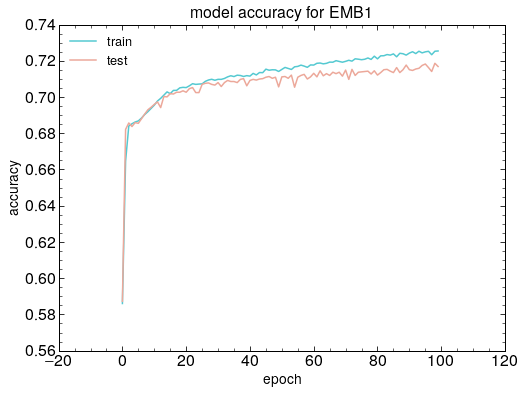

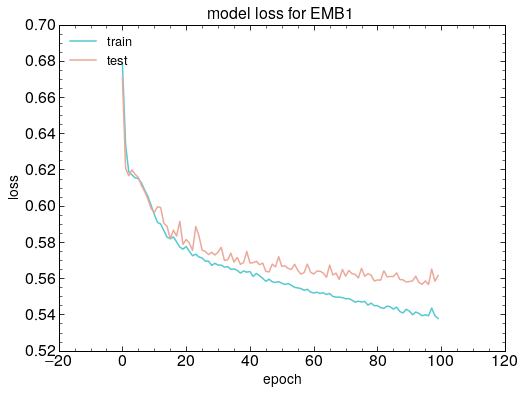

<Figure size 576x432 with 0 Axes>

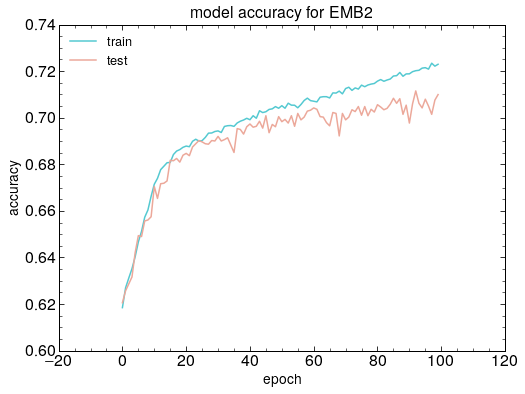

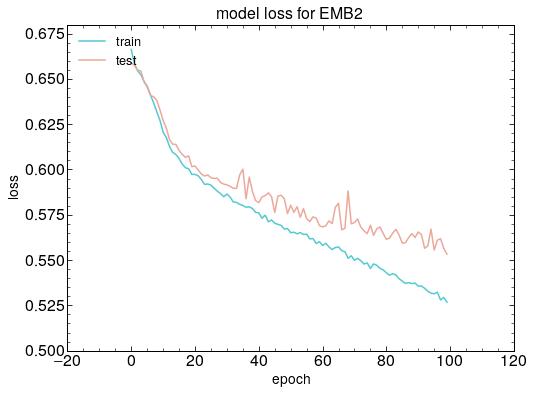

<Figure size 576x432 with 0 Axes>

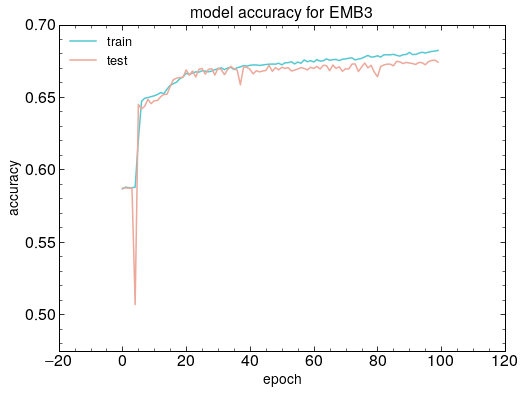

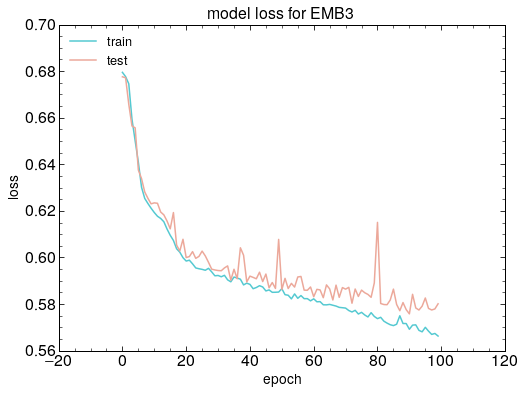

<Figure size 576x432 with 0 Axes>

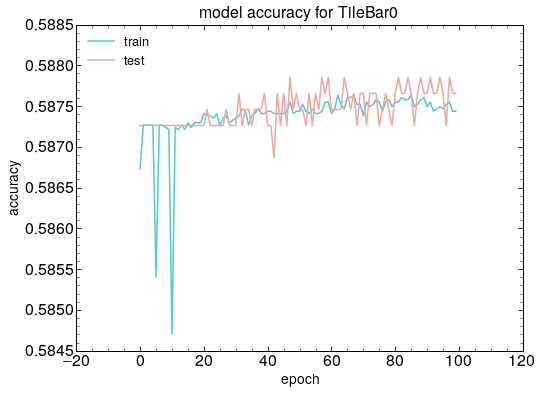

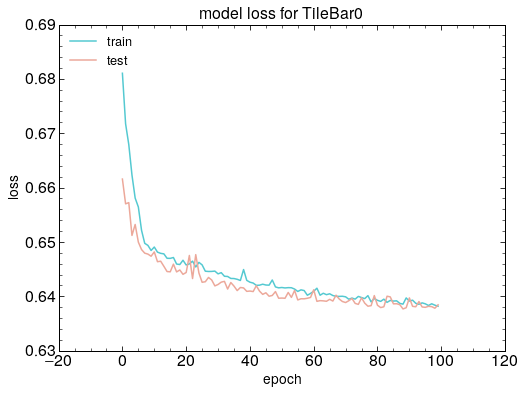

<Figure size 576x432 with 0 Axes>

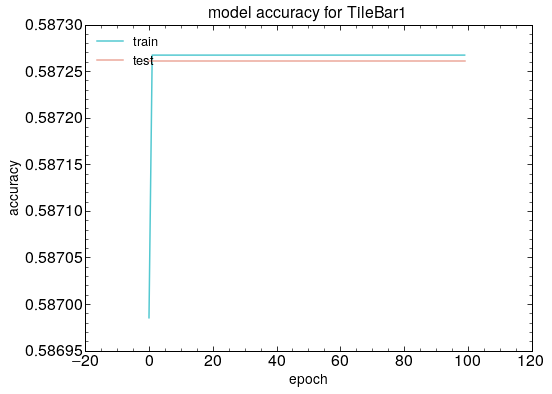

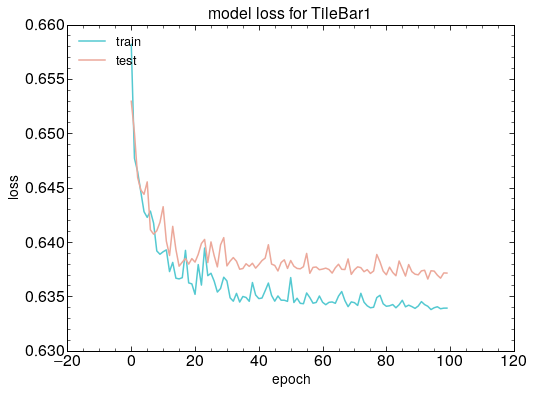

<Figure size 576x432 with 0 Axes>

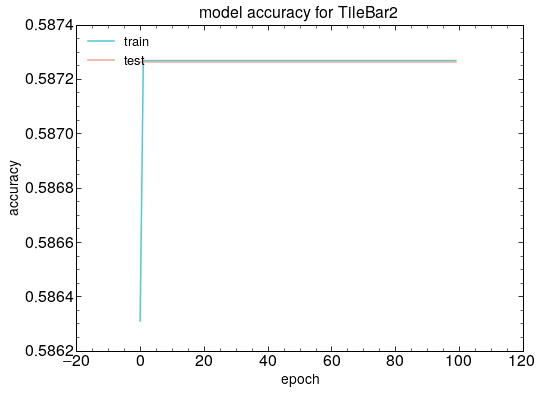

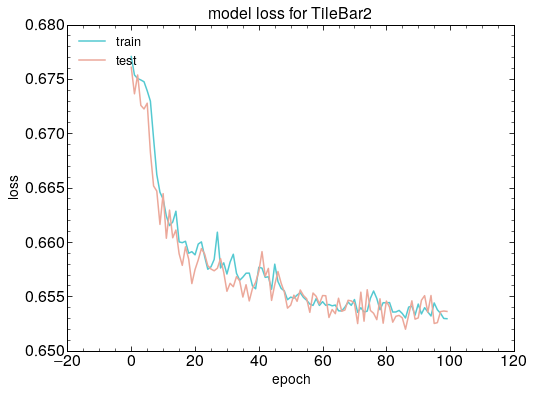

In [19]:
for layer in mu.cell_meta:
#     print(history_flat[layer_i].history.keys())
    plt.cla(); plt.clf()
    fig = plt.figure()
    fig.patch.set_facecolor('white')

    plt.plot(history[layer].history['acc'])
    plt.plot(history[layer].history['val_acc'])
    plt.title('model accuracy for ' + layer)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('Plots/accuracy_' + layer + '.pdf')
    plt.show()


    # summarize history for loss
    fig = plt.figure()
    fig.patch.set_facecolor('white')
    plt.plot(history[layer].history['loss'])
    plt.plot(history[layer].history['val_loss'])
    plt.title('model loss for ' + layer)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig(plotpath + 'loss_' + layer + '.pdf')
    plt.show()

In [20]:
from sklearn.metrics import roc_curve, auc

roc_fpr = {}
roc_tpr = {}
roc_thresh = {}
roc_auc = {}

for layer in mu.cell_meta:
    roc_fpr[layer], roc_tpr[layer], roc_thresh[layer] = roc_curve(
        plabels[pdata_merged.test][:,1],
        scores[layer][pdata_merged.test,1],
        drop_intermediate=False,
    )
    roc_auc[layer] = auc(roc_fpr[layer], roc_tpr[layer])
    print('Area under curve for ' + layer + ': ' + str(roc_auc[layer]))

Area under curve for EMB1: 0.7305795796774635
Area under curve for EMB2: 0.7401842865088688
Area under curve for EMB3: 0.7069783653645444
Area under curve for TileBar0: 0.6104253065728265
Area under curve for TileBar1: 0.5738994175228698
Area under curve for TileBar2: 0.5443132250054753


<Figure size 576x432 with 0 Axes>

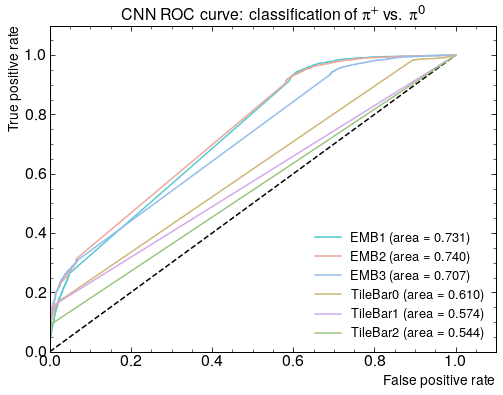

In [22]:
pu.roc_plot([roc_fpr[layer] for layer in mu.cell_meta],
            [roc_tpr[layer] for layer in mu.cell_meta],
            figfile=plotpath + 'roc_cnn_all.pdf',
            labels=['{} (area = {:.3f})'.format(layer, roc_auc[layer]) for layer in mu.cell_meta],
            extra_lines=[[[0, 1], [0, 1]]],
            title='CNN ROC curve: classification of $\pi^+$ vs. $\pi^0$')

In [ ]:
def channels_EMB2G_EMB1F_model_all2():
    with strategy.scope():
        # Here come the 16x16 inputs
        input1 = Input(shape=(6, 16, 16), name='input1')
        x1 = Convolution2D(32, (4, 4), activation='relu', data_format = 'channels_first')(input1)
        # x1 = MaxPool2D(pool_size=(2, 2))(x1)
        x1 = Flatten()(x1)
        x1 = Dense(128, activation='relu')(x1)
        x1 = Dropout(0.2)(x1)
        x1 = Dense(64, activation='relu')(x1)

        emb1_dim = 128*4
        #Here's EMB1 flattened
        input2 = Input(shape=(emb1_dim), name='input2')
        x2 = Dense(emb1_dim, activation='relu')(input2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 2, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 4, activation='relu')(x2)
        x2 = Dropout(0.2)(x2)
        x2 = Dense(emb1_dim / 8, activation='relu')(x2)

        # concatenate outputs from the two networks above
        x = concatenate([x1, x2]) 
        x = Dense(50, activation='relu')(x)    

        # final output
        output = Dense(2, activation='softmax')(x)

        model = Model(inputs = [input1,input2], outputs = [output])
    
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
        return model